# Power Density - All About

This document gives some of the details about power density calculations.

At the moment the power density calculations require points in space and the surface normal vector at each point.  There are some utilities to easily create rectangular surfaces (made up of such point and normal vectors) and some parametric surfaces.  It is also possible to calculate the power density at arbitrary points in space.  These arbitrary points in space are difficult to connect as a surface for visualization by most plotting software (typically they must be on some mesh), nevertheless the calculation is possible.

For the builtin surface types there are simple ways to rotate and translate them in space, typically by giving the power density calculation function the arguments 'rotations=[rx, ry, rz]' and 'translation=[tx, ty, tz]'.  Rotations are done before translation and in the order of rx (rotation about x-axis), ry, rz ad are given in radian.  The translation is done after and given in meters.

Any of these can be run in multi-threaded, GPU, or MPI mode.  Results from running on separate nodes on grid/cloud computing can be combined.


In [1]:
# matplotlib plots inline
%matplotlib inline

# Import the OSCARS SR module
import oscars.sr

# Import OSCARS plots (matplotlib)
from oscars.plots_mpl import *

# Import OSCARS 3D tools (matplotlib)
from oscars.plots3d_mpl import *

# Import OSCARS parametric surfaces
from oscars.parametric_surfaces import *

OSCARS v1.31.05 - Open Source Code for Advanced Radiation Simulation
Brookhaven National Laboratory, Upton NY, USA
http://oscars.bnl.gov
oscars@bnl.gov


In [2]:
# Create an OSCARS SR object
osr = oscars.sr.sr()

In [3]:
# Set default nthreads so I don't have to type it every time
osr.set_nthreads_global(8)

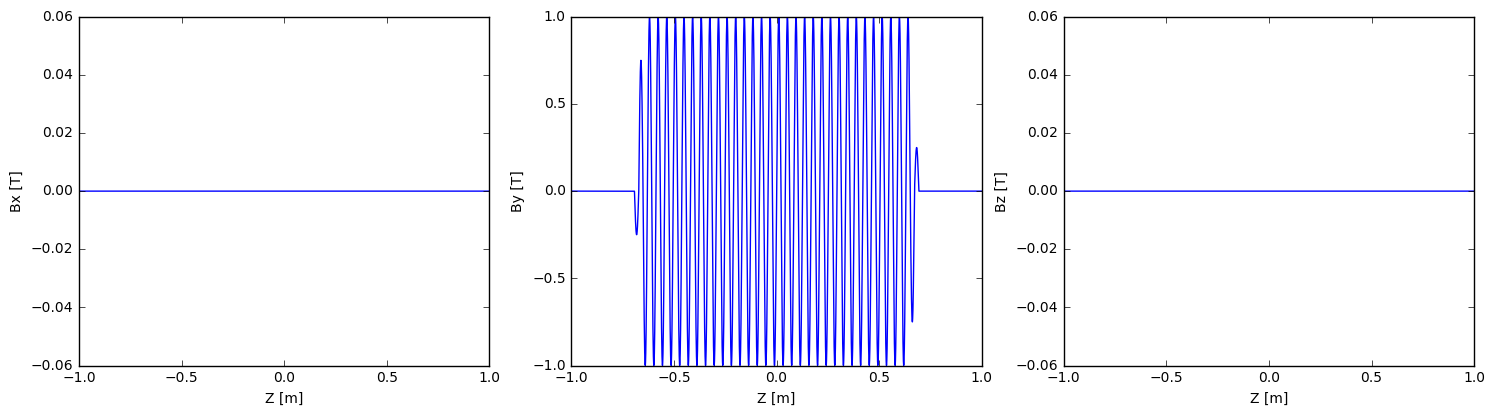

In [4]:
# For these examples we will make use of a simple undulator field
osr.add_bfield_undulator(bfield=[0, 1, 0], period=[0, 0, 0.042], nperiods=31)

# Plot the field
plot_bfield(osr)

## Beam

Add a basic beam somewhat like NSLS2.  Filament beam for simple studies.

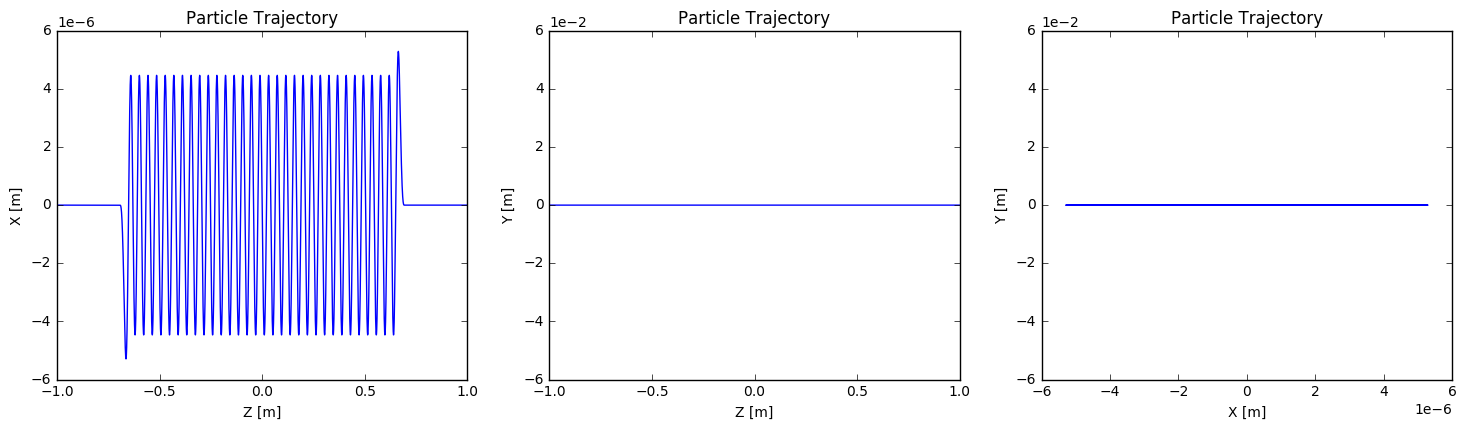

In [5]:
# Add a basic electron beam with zero emittance
osr.set_particle_beam(type='electron',
                      name='beam_0',
                      energy_GeV=3,
                      x0=[0, 0, -1],
                      d0=[0, 0, 1],
                      current=0.500)

# You MUST set the start and stop time for the calculation
osr.set_ctstartstop(0, 2)

# Plot trajectory
osr.set_new_particle()
plot_trajectory_position(osr.calculate_trajectory())

## Power density - Rectangular planes

Calculate the power density on simple rectangular planes.  The 'plane' argument is the initial plane that the surface is in.  From there it can be rotated and translated.  The order of 'XY' or any combination matters since the normal vector is given by X x Y (in the order written in the input).

By default the coordinates in the returned power density are relative to the center of the rectangular grid (not absolute space).  If you want the coordinates in absolute space you can specify dim=3, but I give the warning that this makes plotting rotated surfaces difficult.

Note: This is the recommended method for calculating power densities on rectangular surfaces.  One may also do the same with parametric surfaces (shown later in this tutorial).

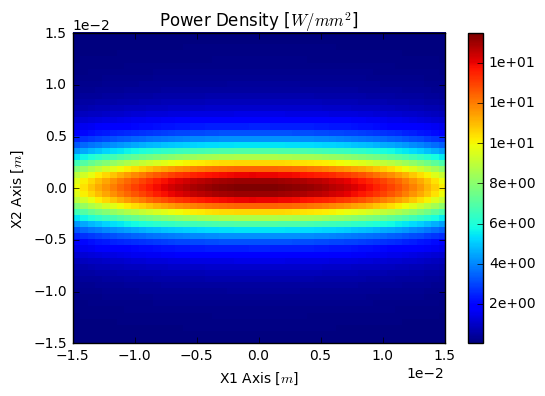

In [6]:
# Calculate power density 30 [m] downstream in the XY plane.
power_density = osr.calculate_power_density_rectangle(plane='XY',
                                                      width=[0.030, 0.030],
                                                      npoints=[51, 51],
                                                      translation=[0, 0, 30]
                                                     )
plot_power_density(power_density)

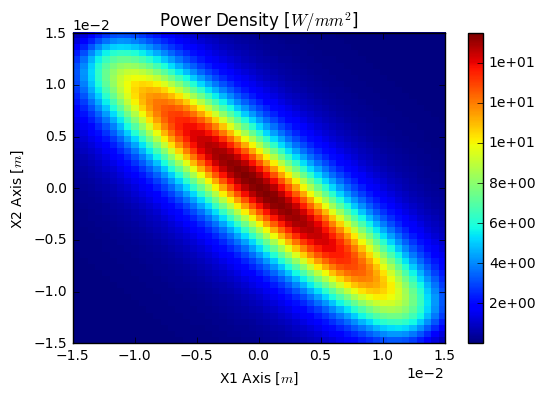

In [7]:
# We can easily rotate the above, here about the z axis.
power_density = osr.calculate_power_density_rectangle(plane='XY',
                                                      width=[0.030, 0.030],
                                                      npoints=[51, 51],
                                                      rotations=[0, 0, osr.pi()/4],
                                                      translation=[0, 0, 30]
                                                     )
plot_power_density(power_density)

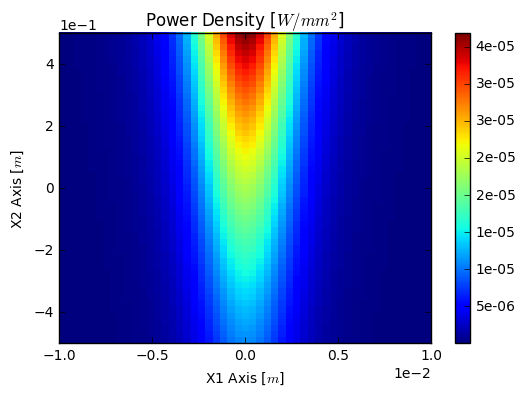

In [8]:
# Calculate the power density on a surface in the XZ plane.
# This can be thought of as the power density on the upper beampipe inner surface
power_density = osr.calculate_power_density_rectangle(plane='XZ',
                                                      width=[0.020, 1.000],
                                                      npoints=[51, 51],
                                                      translation=[0, 0.004, 2]
                                                     )
plot_power_density(power_density)

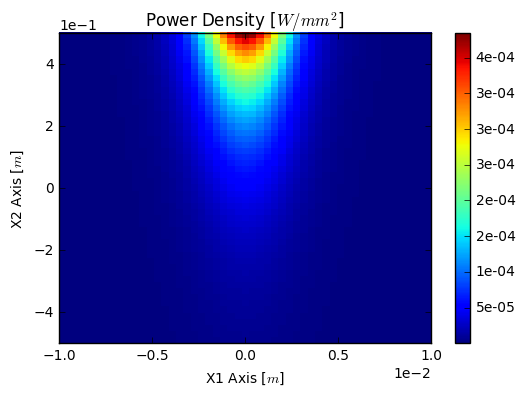

In [9]:
# We'll now take the above plane and tilt is slightly as if it were a tapered beampipe
power_density = osr.calculate_power_density_rectangle(plane='XZ',
                                                      width=[0.020, 1.000],
                                                      npoints=[51, 51],
                                                      rotations=[0.002, 0, 0],
                                                      translation=[0, 0.004, 2]
                                                     )
plot_power_density(power_density)

## Power Density - Parametric Surfaces

We will now calculate the power density on a few parametric surfaces.  A parametric surface in OSCARS is represented by a class.  There is another tutorial which explains how to build your own.

We begin with a simple rectangular surface, then explore some others.  These surfaces come from the oscars.parametric_surfaces module.

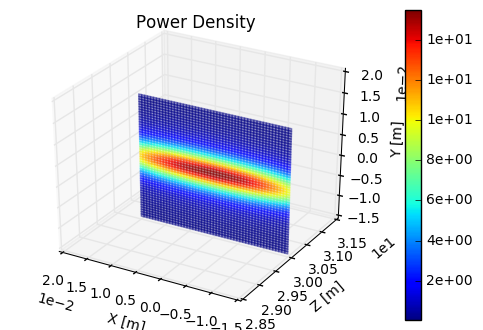

In [10]:
# First create the surface of interest
rectangle = PSRectangle(L=0.030, W=0.030, nu=51, nv=51)

# Run calculation and plotting
power_density_3d(osr, rectangle, translation=[0, 0, 30])

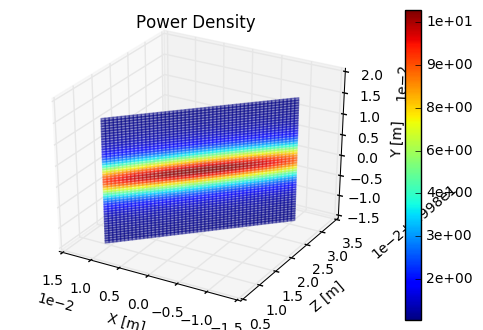

In [11]:
# It is easy to rotate the above and see it in 3D
power_density_3d(osr, rectangle, rotations=[0, osr.pi()/4, 0], translation=[0, 0, 30])

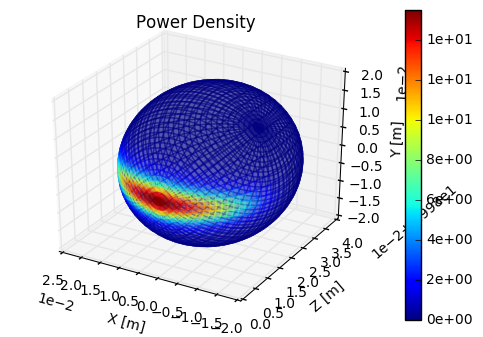

In [12]:
# First create the surface of interest
sphere = PSSphere(R=0.020, nu=51, nv=51)

# Run calculation and plotting
power_density_3d(osr, sphere, translation=[0, 0, 30])

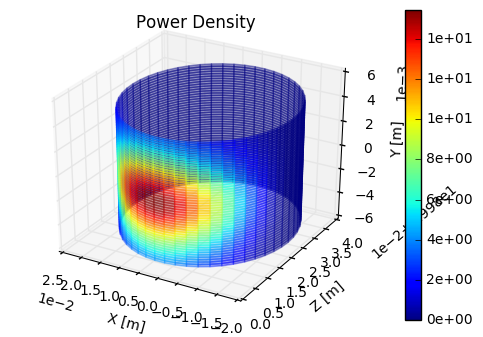

In [13]:
# First create the surface of interest
cylinder = PSCylinder(R=0.020, L=0.010, nu=51, nv=51)

# Run calculation and plotting
power_density_3d(osr, cylinder, rotations=[osr.pi()/2, 0, 0], translation=[0, 0, 30])

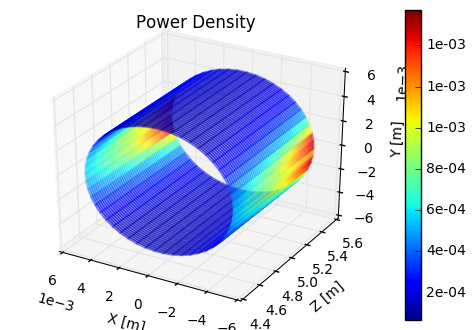

In [14]:
# Let's do a cylinder that is around the photon beam, downstream a bit
cylinder = PSCylinder(R=0.005, L=1.000, nu=51, nv=51)

# Run calculation and plotting.  Here we needed to invert the normal due to the way
# it is defined in the PSCylinder class
power_density_3d(osr, cylinder, translation=[0, 0, 5], normal=-1)

## Multi-particle power density

It is possible to run the power density calculations in multi-particle mode in the case that you have a very large beam.  It is show here for completeness.

In [15]:
# Add a basic electron beam with zero emittance
osr.set_particle_beam(type='electron',
                      name='beam_0',
                      energy_GeV=3,
                      x0=[0, 0, -1],
                      d0=[0, 0, 1],
                      current=0.500,
                      sigma_energy_GeV=0.001*3,
                      beta=[1.5, 0.8],
                      emittance=[0.9e-9, 0.008e-9],
                      horizontal_direction=[1, 0, 0],
                      lattice_reference=[0, 0, 0])

# You MUST set the start and stop time for the calculation
osr.set_ctstartstop(0, 2)

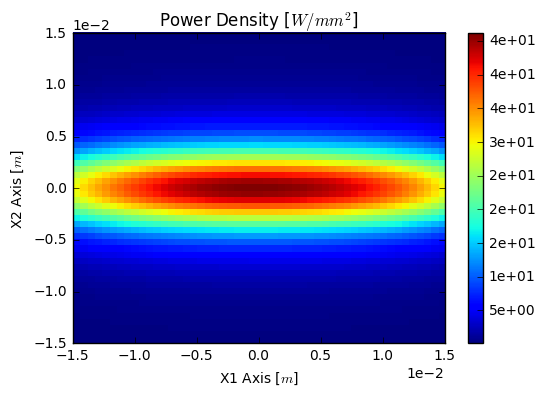

In [16]:
# Calculate power density 30 [m] downstream in the XY plane.
power_density = osr.calculate_power_density_rectangle(plane='XY',
                                                      width=[0.030, 0.030],
                                                      npoints=[51, 51],
                                                      translation=[0, 0, 30],
                                                      nparticles=3
                                                     )
plot_power_density(power_density)

In [18]:
# If you want to convert the notebook to HTML
import os
os.system('jupyter nbconvert --to html AllAbout_PowerDensity.ipynb')

0